<img src="../../images/QISKit.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*The Deutsch-Josza Algorithm*_ 

The [Deutsch-Josza algorithm](http://rspa.royalsocietypublishing.org/content/439/1907/553) is one of the earliest examples demonstrating the power of quantum computers. The algorithm deals with guessing the type of a hidden Boolean function given as an oracle. The Boolean function is promised to be either balanced, i.e., whose values are $0$ on half of its inputs, or constant, i.e., whose values are the same on all inputs. 

Classically, in the best case two queries to the oracle can determine if the hidden Boolean function is balanced. But in the worst case at least half of the inputs must be queried to determine if the hidden Boolean function is constant for all inputs. On the other hand, the Deutsch-Josza algorithm can determine the Boolean function with one quantum query.   

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Rudy Raymond

## Introduction <a id='introduction'></a>

The algorithm in this notebook follows that in [Cleve et al.1997](https://arxiv.org/pdf/quant-ph/9708016.pdf). We assume that the input to the oracle $f$ is a $n$-bit string. Namely, for each $x \in \{0,1\}^n$ the value of $f(x)$ is promised to be either constant, i.e., the same for all $x$, or balanced, i.e., there are exactly half of $n$-bit string whose $f(x) = 0$. 

## The Algorithm

The algorithm is quite simple as follows.
1. Prepare two quantum registers initialized to zero. The first is a $n$-qubit reqister for querying the oracle and the second is a one-qubit register for storing the answer of the oracle

2. Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.

3. Flip the second register and apply the Hadamard gate. This is to store the answer of the oracle in the phase.

4. Query the oracle

5. Apply the Hadamard gate to the first register

6. Measure the first register. If it is non-zero, then conclude that the hidden Boolean function is balanced. Otherwise, conclude that it is constant. 

## The Circuit <a id="circuit"></a>

We now implement the Deutsch-Josza algorithm with QISKit by first preparing the environment.

In [1]:
# useful additional packages 
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing the QISKit
from qiskit import QuantumProgram
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except:
    qx_config = {
        "APItoken":"YOUR_TOKEN_HERE",
        "url":"https://quantumexperience.ng.bluemix.net/api"}

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

We first set the length of the $n$-bit string. 

In [2]:
n = 15 #the length of the first register for querying the oracle 

We then use QISKit to program the Bernstein-Vazirani algorithm.

In [3]:
Q_program = QuantumProgram()
Q_program.set_api(qx_config['APItoken'], qx_config['url']) # set the APIToken and API url

#Choose a type of oracle at random. With probability half it is constant, 
#and with the same probability it is balanced
oracleType, oracleValue = np.random.randint(2), np.random.randint(2)

if oracleType == 0:
    print("The oracle returns a constant value ", oracleValue)
else:
    print("The oracle returns a balanced function")
    a = np.random.randint(1,2**n) #this is a hidden parameter for balanced oracle. 

# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = Q_program.create_quantum_register("qr", n+1) #all qubits are initialized to zero
# for recording the measurement on the first register
cr = Q_program.create_classical_register("cr", n)

circuitName = "DeutschJosza"
djCircuit = Q_program.create_circuit(circuitName, [qr], [cr])

#Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
for i in range(n):
    djCircuit.h(qr[i])

#Flip the second register and apply the Hadamard gate.
djCircuit.x(qr[n])
djCircuit.h(qr[n])
    
#Apply barrier to mark the beginning of the oracle
djCircuit.barrier()

if oracleType == 0:#If the oracleType is "0", the oracle returns oracleValue for all input. 
    if oracleValue == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.iden(qr[n])
else: #Otherwise, it returns the inner product of the input with a (non-zero bitstring) 
    for i in range(n):
        if (a & (1 << i)):
            djCircuit.cx(qr[i], qr[n])
        
#Apply barrier to mark the end of the oracle
djCircuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    djCircuit.h(qr[i])
    
#Measurement
for i in range(n):
    djCircuit.measure(qr[i], cr[i])

The oracle returns a constant value  0


## Experiment with Simulators

We can run the above circuit on the simulator. 

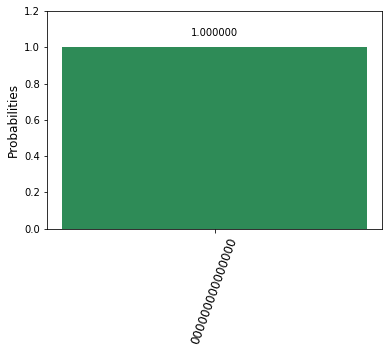

In [4]:
backend = "ibmqx_hpc_qasm_simulator"
shots = 1000
results = Q_program.execute([circuitName], backend=backend, shots=shots)
answer = results.get_counts(circuitName)

plot_histogram(answer)

Repeating the above experiments, we can see that the result of the measurement is all-zero bitstring if the oracle returns a constant value, or non-zero bitstring otherwise.

## Experiment with Real Devices

We can run the circuit on the real device as below. However, notice that because the real devices are noisy, we cannot obtain the type of oracles with certainty unlike when running the experiments with simulators. The Deutsch-Josza algorithm only shows the superiority of quantum computers against exact classical algorithms: when allowing some error, classically we can determine the type of the hidden Boolean function with constant number of queries. This is asymptotically the same as the case with quantum computers. 

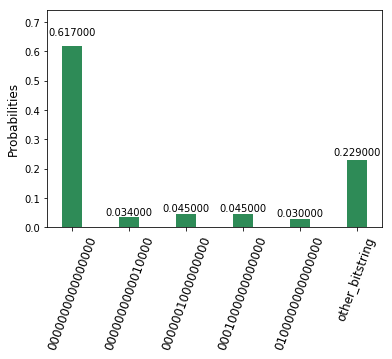

{'0000000000000000': 617, '0000000000010000': 34, '0000001000000000': 45, '0001000000000000': 45, '0100000000000000': 30, 'other_bitstring': 229}


In [5]:
backend = "ibmqx5"
shots = 1000 
if Q_program.get_backend_status('ibmqx5')['available'] == True:
    results = Q_program.execute([circuitName], backend=backend, shots=shots, timeout=480)
    answer = results.get_counts(circuitName)

    threshold = int(0.03 * shots) #the threshold of plotting significant measurements
    filteredAnswer = {k: v for k,v in answer.items() if v >= threshold} #filter the answer for better view of plots

    removedCounts = np.sum([ v for k,v in answer.items() if v < threshold ]) #number of counts removed 
    filteredAnswer['other_bitstring'] = removedCounts  #the removed counts is assigned to a new index

    plot_histogram(filteredAnswer)

    print(filteredAnswer)

In [1]:
%run "../../version.ipynb"

Package,Version
QISKit,0.4.10
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
